# exp077   
[Notion](https://www.notion.so/exp077-710ca4e3dddd4b498371fa49f35f9065?pvs=4)    
2.5Dモデル(lsk, low, high)(exp075)の推論及び評価を行う.  
beモデルは最も精度の高いexp068のe2の予測結果を用いる.  
結果が良ければ、3d lskモデルとの平均も試す.  
Copy from: exp077 <- exp032.ipynb <- exp028.ipynb <- exp025.ipynb <- exp021.ipynb <- exp018.ipynb <- exp012.ipynb  

In [1]:
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from typing import Tuple, Any, Dict, Optional

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# リポジトリtopに移動
while os.path.basename(os.getcwd()) != 'rsna-2023':
    os.chdir('../')
    if os.getcwd() == '/':
        raise Exception('Could not find project root directory.')
    
from src.data_io import load_dicom_series
from src.segmentation.dataset import TestDataset as SegTestDataset
from src.segmentation.model import load_models as seg_load_models
from src.segmentation.trainer import inference as seg_inference
from src.classification.dataset import TestDatasetBowelExtra, TestDatasetSolidOrgans
from src.image_processing import apply_preprocess, crop_organ, kidney_split, resize_volume, \
    apply_postprocess, kidney_specific, resize_3d, resize_1d, create_bbox, crop_image_from_bbox
from src.classification.model import load_models as cls_load_models
from src.classification.trainer import inference as cls_inference
from src.metrics import score, create_training_solution, normalize_probabilities_to_one
from src.classification.dataset import load_df

# Configs

In [2]:
class CFG_INF:
    exp_name = 'exp_077'
    # evaluation時：'train', submission時：'test'
    phase = 'train'
    base_dir = 'data/rsna-2023-abdominal-trauma-detection'
    image_dir = f'data/rsna-2023-abdominal-trauma-detection/{phase}_images'
    # dataframeはこのconfigにもたせ、phaseで対応できるようにする.
    if phase == 'train':
        df = pd.read_csv(os.path.join(base_dir, 'train.csv'))
    elif phase == 'test':
        df = pd.read_csv(os.path.join(base_dir, 'sample_submission.csv'))
    df_series_meta = pd.read_csv(os.path.join(base_dir, f'{phase}_series_meta.csv'))
    image_size = (512, 512)
    # sample submissionで極端にスライス数が少ない場合があるため対応.
    min_slices = 10
    # 推論時間制限のため
    max_slices = 500
    max_series = 2
    model_save_dir = "outputs"
    lsk_model_mode = 'final'
    be_model_mode = 'e2'
    lsk_2d_model_mode = 'e10'

class CFG_LSK:
    exp_name = 'exp_056'
    # model config
    # timm backbone
    backbone = 'efficientnet-b4'
    n_ch = 1
    expand_ch_dim = True
    crop_body = False
    # n_class: healthy, low, high
    n_class = 3
    # hyper params
    wl = 0
    ww = 1000
    init_lr = 5e-4
    min_lr = 1e-6
    weight_decay = 1e-4
    image_size = (128, 128, 160)
    batch_size = 32
    amp = False
    eps = 1e-8
    n_epoch = 24
    pretrain = False
    freeze_epochs = 0
    noaug_epochs = 1
    # fold config
    n_fold = 6
    include_evaluation = False
    train_folds = 1
    # path
    image_dir = "data/dataset002"
    model_save_dir = "outputs"
    # other config
    seed = 42
    num_workers = 4
    num_gpus = 2
    progress_bar = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    class_weight=torch.tensor([1.0, 1.0, 1.0]).to(device)

class CFG_BE:
    exp_name = 'exp_068'
    # model config
    # timm backbone
    backbone = 'efficientnet_b4'
    # n_ch: z軸方向のスライス数
    n_ch = 5
    expand_ch_dim = False
    # n_class: bowel_injury, extravasation
    # sample weighted: 4class
    n_class = 1
    label_smoothing = None #Optional(float)
    crop_body = True
    # hyper params
    wl = 0
    ww = 1000
    init_lr = 5e-5
    min_lr = 1e-7
    weight_decay = 1e-4
    image_size = (448, 448)
    batch_size = 32
    amp = False
    eps = 1e-8
    n_epoch = 24
    iteration_per_epoch = 500
    pretrain = True
    freeze_epochs = 1
    noaug_epochs = 1
    # fold config
    n_fold = 6
    include_evaluation = False
    train_folds = 1
    # path
    image_dir = "data/dataset001"
    model_save_dir = "outputs"
    # other config
    seed = 42
    num_workers = 4
    num_gpus = 2
    progress_bar = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CFG_BODY:
    exp_name = 'exp_036'
    # model config
    backbone = 'efficientnet-b3'
    n_ch = 1
    expand_ch_dim = False
    n_class = 1
    crop_body = False
    # hyper params
    wl = 0
    ww = 400
    init_lr = 1e-3
    min_lr = 1e-6
    weight_decay = 1e-4
    image_size = (512, 512)
    batch_size = 32
    amp = True
    n_epoch = 10
    # iteration_per_epoch = 200
    pretrain = True
    freeze_epochs = 0
    noaug_epochs = 1
    # fold config
    n_fold = 6
    include_evaluation = False
    train_folds = 1
    # path
    image_dir = "data/dataset001/train_images"
    mask_dir = "data/dataset004/segmentations"
    model_save_dir = "outputs"
    # other config
    seed = 42
    num_workers = 0
    num_gpus = 2
    progress_bar = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CFG_LSK_2D:
    exp_name = 'exp_075'
    # model config
    # timm backbone
    backbone = 'efficientnet_b4'
    # n_ch: z軸方向のスライス数
    n_ch = 5
    expand_ch_dim = False
    # n_class: lsk*(low+high)
    n_class = 6
    label_smoothing = None #Optional(float)
    crop_body = True
    # hyper params
    wl = 0
    ww = 1000
    init_lr = 5e-5
    min_lr = 1e-7
    weight_decay = 1e-4
    image_size = (448, 448)
    batch_size = 32
    amp = False
    eps = 1e-8
    n_epoch = 14
    iteration_per_epoch = 500
    pretrain = True
    freeze_epochs = 1
    noaug_epochs = 1
    # fold config
    n_fold = 6
    include_evaluation = False
    train_folds = 1
    # path
    image_dir = "data/dataset001"
    model_save_dir = "outputs"
    # other config
    seed = 42
    num_workers = 4
    num_gpus = 2
    progress_bar = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # b_healty, b_injury, e_healty, e_injury
    class_weight=torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).to(device)

In [3]:
# organs dict (for SEG and LSK models)
organ_index_dict_inv = {
    0: 'liver',
    1: 'spleen',
    2: 'kidney',
    3: 'bowel'
}
organ_index_dict = {v: k for k, v in organ_index_dict_inv.items()}

# labels dict (for BE models)
label_index_dict_inv = {
    0: 'bowel',
    1: 'extravasation'
}

lsk_2d_model_label_info = {
    0: "liver_low",
    1: "liver_high",
    2: "spleen_low",
    3: "spleen_high",
    4: "kidney_low",
    5: "kidney_high",
}

In [4]:
def load_series_from_dataset(dir_: str, max_slices: Optional[int]=None)-> np.ndarray:
    """seriesを読み込む."""
    path_list = os.listdir(dir_)
    path_list = [[int(path.replace(".npy","")), path] for path in path_list]
    path_list.sort()
    path_list = [path[1] for path in path_list]
    if max_slices is not None:
        step = (len(path_list) + max_slices - 1) // max_slices
        path_list = path_list[::step]
    arr = []
    for path in path_list:
        arr.append(np.load(os.path.join(dir_, path)))
    return np.array(arr)

def load_image(path: str) -> np.ndarray:
    """画像の読み込み.
    Args:
        path (str): 画像のパス.
    Returns:
        numpy.ndarray: 画像.
    Note:
        現在読み込む画像の形式は.png, .npy, .npzのみ対応.
        cv2.IMREAD_UNCHANGED: 16bit画像やアルファチャンネルを考慮した読み込み.
    """
    if path.endswith(".png"):
        image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    elif path.endswith(".npy"):
        image = np.load(path)
    elif path.endswith(".npz"):
        image = np.load(path)["arr_0"]
    else:
        raise Exception(f"unexpected image format: {path}")
    return image

In [51]:
class Inference:
    """推論パイプライン."""
    def __init__(self,CFG_INF: Any, CFG_LSK: Any, CFG_BE: Any, CFG_BODY: Any, CFG_LSK_2D: Any):
        self.CFG_INF = CFG_INF
        self.CFG_LSK = CFG_LSK
        self.CFG_BE = CFG_BE
        self.CFG_BODY = CFG_BODY
        self.CFG_LSK_2D = CFG_LSK_2D

        self.lsk_models = cls_load_models(CFG_LSK, mode=self.CFG_INF.lsk_model_mode)
        self.be_models = cls_load_models(CFG_BE, mode=self.CFG_INF.be_model_mode, framework="timm")
        self.lsk_2d_models = cls_load_models(CFG_LSK_2D, mode=self.CFG_INF.lsk_2d_model_mode, framework="timm")

        # z軸を求めるためのorgan label
        self.organ_label = pd.read_csv("outputs/exp065/segmentation_result.csv")

        # モデルの読み込み
        self.body_models = seg_load_models(self.CFG_BODY, mode="final")
    
    def __call__(self, pid: int) -> tuple:
        """inference process.
        1. load images from dicom files.
        2. create segmentation masks.
        3. create liver, spleen, kidney volumes.
        4. inference lsk models.
        5. inference be models.
        Args:
            pid (int): patient id.
        Return example:
            dict: {
            'pid': 0,
            'bowel_healthy': 0.0,
            'bowel_injury': 0.0,
            'extravasation_healthy': 0.0,
            'extravasation_injury': 0.0,
            'kidney_healthy': 0.0,
            'kidney_low': 0.0,
            'kidney_high': 0.0,
            'liver_healthy': 0.0,
            'liver_low': 0.0,
            'liver_high': 0.0,
            'spleen_healthy': 0.0,
            'spleen_low': 0.0,
            'spleen_high': 0.0
            }
        Note:
            - １症例に複数シリーズ存在する場合、各シリーズに対して推論を行い、全予測結果の最大値を採用する.
            - 推論時間的に厳しければ、最初のシリーズのみを採用するなど検討.
        """
        df_study = self.CFG_INF.df_series_meta[self.CFG_INF.df_series_meta['patient_id']==pid].reset_index(drop=True)
        # df_study内のそれぞれのシリーズを取得して、画像枚数に対して降順にソート.
        df_study = self.get_slices_and_sort(df_study)
        preds = defaultdict(list)
        for sid in df_study['series_id'].to_list()[:self.CFG_INF.max_series]:
            data = self.load_data(pid, sid)
            if data is None:
                continue
            # lsk_preds = self.lsk_prediction(pid, sid)
            # be_preds = self.be_prediction(data)
            lsk_2d_preds = self.lsk_2d_prediction(pid, sid, data)
            for idx, label in lsk_2d_model_label_info.items():
                pred = np.array([lsk_2d_preds[:,idx]]) # [:,idx] when postprocess is not applied
                preds[label].append(pred)
            return preds
            for idx, organ in organ_index_dict_inv.items():
                if idx == 3:
                    continue
                preds[organ].append(lsk_preds[idx])
            for idx, label in label_index_dict_inv.items():
                pred = np.array([be_preds[idx]])
                preds[label].append(pred)
        ret = {'patient_id': pid}
        for k,v in preds.items():
            v = np.array(v)
            ret[k] = np.max(v, axis=0) # seriesごとのmax
        ret = self.convert_submission_format(ret)
        return ret

    def load_data(self, pid: int, sid: int)-> np.ndarray:
        """dicomから画像を読み込む.
        Args:
            pid (int): patient id.
            sid (int): series id.
        Returns:
            np.ndarray: (Z, H, W) normalized CT series.
        Note:
            - preprocessは全モデル共通なので、ここで行う.
            - H, Wはすべてself.CFG_INF.image_sizeにresizeされる.
        """
        series_path = os.path.join(self.CFG_BE.image_dir, 'train_images', str(pid), str(sid))
        # sample submissionでこういう例が存在する.
        if not os.path.exists(series_path):  
            return None
        image_arr = load_series_from_dataset(series_path, self.CFG_INF.max_slices)
        # windowingはしない
        image_arr = apply_preprocess(image_arr, resize=self.CFG_INF.image_size, do_windowing=False)
        # sample submission対応
        if len(image_arr) < self.CFG_INF.min_slices:
            image_arr = resize_1d(image_arr, self.CFG_INF.min_slices, axis=0)
        return image_arr
    
    def get_slices_and_sort(self, df_study: pd.DataFrame)-> pd.DataFrame:
        """シリーズのスライス数を取得して、スライス数に対して降順にソートする.
        Args:
            df_study (pd.DataFrame): series meta dataframe.
        Returns:
            pd.DataFrame: sorted series meta dataframe.
        """
        pid = df_study['patient_id'][0]
        df_study['n_slices'] = 0
        for i in range(len(df_study)):
            sid = df_study['series_id'][i]
            series_path = os.path.join(self.CFG_INF.image_dir, str(pid), str(sid))
            if os.path.exists(series_path):
                df_study['n_slices'][i] = len(os.listdir(series_path))
        df_study = df_study.sort_values(by='n_slices', ascending=False)
        return df_study
    
    def lsk_prediction(self, pid: int, sid: int)-> np.ndarray:
        """liver, spleen, kidneyの予測値を返す.
        Args:
            pid: patient id
            sid: series id
        Returns:
            np.ndarray: (organs, grades).
        """
        volumes = self.get_lsk_volumes(pid, sid) # (organs, z, h, w)
        lsk_iterator = self.pseudo_iterator(self.CFG_LSK, volumes)
        pred = cls_inference(self.CFG_LSK, self.lsk_models, lsk_iterator)
        return pred
    
    def get_z_indices(self, pid: int, sid: int)-> Tuple[int, int]:
        """提出用コードでは処理異なるので注意."""
        df = self.organ_label
        df = df[(df['patient_id']==pid) & (df['series_id']==sid)]
        z_min = 10**5
        z_max = 0
        for organ in ["liver", "spleen", "kidney"]:
            z_min = min(z_min, df[f'{organ}_zmin'].values[0])
            z_max = max(z_max, df[f'{organ}_zmax'].values[0])
        return z_min, z_max
    
    def z_indices_cut(self, pid: int, sid: int, data: np.ndarray, bboxes: list):
        """z軸方向に対して、必要なスライスのみを抽出する.
        Args:
            pid: patient id
            sid: series id
            data: (Z, H, W)
            bboxes: (Z, 4)
        Returns:
            np.ndarray: (Z, H, W)
        """
        z_min, z_max = self.get_z_indices(pid, sid)
        z_min = max(0, z_min)
        z_max = min(len(data), z_max)
        data = data[z_min:z_max]
        bboxes = bboxes[z_min:z_max]
        return data, bboxes



    def get_lsk_volumes(self, pid: int, sid: int)->Dict[str, np.ndarray]:
        """Segmentationからliver, spleen, kidneyのvolume dataを作成.
        Args:
            pid: patient id
            sid: series id
        Returns:
            np.ndarray: (organs, z, h, w).
        Note:
            - organsはliver, spleen, kidneyの順番.
            - この関数内でCFG.LSK.image_sizeのreshapeまで行う.
            - 腎臓は左右を分離してからくっつけ直すという特殊な処理が必要.
        """
        arr = []
        for idx, organ in organ_index_dict_inv.items():
            if idx == 3:
                continue
            path = os.path.join(self.CFG_LSK.image_dir, str(pid), str(sid), f"{organ}.npy")
            if organ == "kidney":
                # 解剖学的な左右を、画像上の左右に置き換えて読み込み
                l, r = (
                    path.replace("kidney.npy", "kidney_r.npy"),
                    path.replace("kidney.npy", "kidney_l.npy"),
                )
                if os.path.exists(l):
                    l = load_image(l)
                else:
                    l = np.zeros(self.CFG_LSK.image_size)
                if os.path.exists(r):
                    r = load_image(r)
                else:
                    r = np.zeros(self.CFG_LSK.image_size)
                img_cropped = kidney_specific(self.CFG_LSK, l, r)
            else:
                organ_segment = load_image(path)
                img_cropped = resize_3d(organ_segment, self.CFG_LSK.image_size)
                
            arr.append(img_cropped)
        arr = np.stack(arr, axis=0)
        return arr
    
    def be_prediction(self, data: np.ndarray)-> np.ndarray:
        """2.5Dモデルの推論を行う.
        Args:
            data: (Z, H, W).
        Returns:
            np.ndarray: [bowel_injury_pred, extravasation_injury_pred].
            example: [0.1, 0.9].
        """
        bboxes = self.create_bbox(data) # bounding boxを作成
        self.bboxes = bboxes
        be_iterator = self.pseudo_iterator(self.CFG_BE, data, bboxes)
        pred = cls_inference(self.CFG_BE, self.be_models, be_iterator)
        pred = self.be_prediction_postprocess(pred)
        return pred
    
    def get_numerical_prediction(self, pred: np.ndarray)->np.ndarray:
        """連続する10スライスの予測値が十分に大きい場合、それにふさわしい予測値を返す."""
        ret = 0
        slices = 10
        for i in range(0,len(pred)-slices):
            ret = max(ret, np.mean(pred[i:i+slices]))
        return ret
    
    def be_prediction_postprocess(self, pred: np.ndarray)-> np.ndarray:
        """スライスごとの予測をシリーズの予測に変換する.
        Args:
            pred: (len(data),['bowel_injury', 'extravasation_injury']).
        Returns:
            np.ndarray: ['bowel_injury', 'extravasation_injury'].
        Note:
            - 予測値の最大値から外れ値を考慮した2%percentileを採用する.
        """
        assert self.CFG_BE.n_class == 1
        extravasation = pred[:, 0]
        extravasation = extravasation[2:-2] # dummy両端
        extravasation = self.get_numerical_prediction(extravasation)
        bowel = 0
        return np.array([bowel, extravasation])

    def pseudo_iterator(self, CFG: Any, images: np.ndarray, bboxes: Optional[list]=None)-> tuple:
        """evaluation iterator.
        Args:
            CFG: config.
            images: (batch dim, H, W) or (batch dim, Z, H, W).
        """
        # モデルごとにwindowingが異なるため、ここで行う.
        images = apply_preprocess(images, wl=CFG.wl, ww=CFG.ww)
        batch = CFG.batch_size
        length = len(images)
        arr = []
        if not CFG.expand_ch_dim:
            images = self.add_dummy_array(CFG, images)
        for i in range(length):
            if CFG.expand_ch_dim:
                img = images[i]
                img = img[np.newaxis, ...]
            else:
                img = images[i:i+CFG.n_ch]
            if CFG.crop_body:
                bbox = bboxes[i]
                img = crop_image_from_bbox(img, bbox, ch_first=True)
                # ch_last
                img = np.transpose(img, (1, 2, 0))
                img = cv2.resize(img, CFG.image_size)
                # ch_first
                img = np.transpose(img, (2, 0, 1))
            arr.append(img)
            if i != 0 and (i%batch==0 or i == length-1):
                arr = np.stack(arr, axis=0)
                arr = torch.from_numpy(arr.astype(arr.dtype, copy=False))
                yield arr
                arr = []

    def add_dummy_array(self, CFG: Any, images: np.ndarray)-> np.ndarray:
        """chが複数ある場合に、事前に0配列を追加しておく."""
        add_ch = CFG.n_ch//2
        arr = []
        img = np.zeros_like(images[0])
        for i in range(add_ch):
            arr.append(img)
        arr.extend(images)
        for i in range(add_ch):
            arr.append(img)
        arr = np.stack(arr, axis=0)
        return arr
    
    def convert_submission_format(self, pred: dict)->dict:
        """提出形式に変換する."""
        converted = dict()
        for idx, organ in organ_index_dict_inv.items():
            if idx == 3:
                continue
            for idx, grade in enumerate(['healthy', 'low', 'high']):
                converted[f'{organ}_{grade}'] = pred[organ][idx]
        for idx, label in label_index_dict_inv.items():
            converted[f'{label}_healthy'] = 1 - pred[label][0]
            converted[f'{label}_injury'] = pred[label][0]

        converted['patient_id'] = pred['patient_id']
        return converted
    
    def create_bbox(self, data: np.ndarray)-> np.ndarray:
        """body_crop用セグメンテーションモデルを用いてbboxを抽出、その後画像に適用.
        Args:
            data: (Z, H, W).
        Returns:
            list: (Z, 4). zは必ずしもlen(data)と一致しない.
        Note:
            returnsのshapeはCFG_BE.image_sizeにresize済み.
            提出用notebook (apply_preprocessがpseudo_iteratorに組み込まれている場合)はwindowingをこっちに組み込む.  
            計算量削減のため、最大32枚しか推論しない.
        """
        step = max(1, (len(data)+32-1) // 32)
        data_batch = data[::step]
        body_iterator = self.pseudo_iterator(self.CFG_BODY, data_batch)
        pred = seg_inference(self.CFG_BODY, self.body_models, body_iterator)
        masks = (pred > 0.5).astype(np.uint8)
        masks = apply_postprocess(self.CFG_BODY, masks)
        bboxes = []
        for mask in masks:
            bbox = create_bbox(mask)
            bboxes.append(bbox)
        bboxes_series = []
        for i, bbox in enumerate(bboxes):
            for j in range(step):
                bboxes_series.append(bbox)
        return bboxes_series
    
    def lsk_2d_prediction(self, pid: int, sid: int, data: np.ndarray)-> np.ndarray:
        bboxes = self.create_bbox(data) # bounding boxを作成
        self.bboxes = bboxes
        data, bboxes = self.z_indices_cut(pid, sid, data, bboxes)
        if len(data) == 0:
            return np.zeros((1, self.CFG_LSK_2D.n_class))
        lsk_2d_iterator = self.pseudo_iterator(self.CFG_LSK_2D, data, bboxes)
        pred = cls_inference(self.CFG_LSK_2D, self.lsk_2d_models, lsk_2d_iterator)
        # pred = self.be_prediction_postprocess(pred)
        return pred

In [52]:
df_solid_organ = load_df(CFG_LSK)
# fold 0のpatient_idを取得
pids = df_solid_organ[df_solid_organ["fold"] == 0]["patient_id"].unique()
df_all = pd.read_csv(os.path.join(CFG_INF.base_dir, 'train.csv'))
train_pids = df_solid_organ[df_solid_organ["fold"] != 0]["patient_id"].unique()
valid_pids = df_solid_organ[df_solid_organ["fold"] == 0]["patient_id"].unique()
df_train = df_all[df_all["patient_id"].isin(train_pids)].reset_index(drop=True)
df_valid = df_all[df_all["patient_id"].isin(valid_pids)].reset_index(drop=True)

In [53]:
inference_instance = Inference(CFG_INF, CFG_LSK, CFG_BE, CFG_BODY, CFG_LSK_2D)

In [55]:
results = []
for pid in tqdm(df_valid['patient_id'].to_list()):
    result = inference_instance(pid)
    results.append(result)

100%|██████████| 525/525 [12:34<00:00,  1.44s/it]


In [56]:
import pickle
# resultsを保存
dir_ = os.path.join(CFG_INF.model_save_dir, CFG_INF.exp_name)
os.makedirs(dir_, exist_ok=True)#
path = os.path.join(dir_, "lsk_2d_results.pkl")
with open(path, 'wb') as f:
   pickle.dump(results, f)

# resultsを読み込み
# with open(path, 'rb') as f:
#    results = pickle.load(f)

In [42]:
# exp068 result
import pickle
path = "outputs/exp_070/results_seg004_lsk056_be068.pkl"
with open(path, 'rb') as f:
    exp068_results = pickle.load(f)

In [57]:
def get_numerical_prediction(pred: np.ndarray)->np.ndarray:
    "連続する10スライスの予測値が十分に大きい場合、それにふさわしい予測値を返す."
    ret = 0
    slices = 10
    for i in range(0,len(pred)-slices):
        ret = max(ret, np.mean(pred[i:i+slices]))
            # print(ret)
    return ret

In [58]:
result_clean = []
for idx, (pid, result) in tqdm(enumerate(zip(df_valid['patient_id'].to_list(), results))):
    result_patient = {
        "patient_id": pid,
    }
    for label, pred in result.items():
        series_max = []
        for pred_series in pred:
            # (1, slices) -> (slices,)
            pred_series = pred_series[0]
            # p = 90
            # pred_series_to_one = np.percentile(pred_series, p)

            pred_series = pred_series[2:-2]
            pred_series_to_one = get_numerical_prediction(pred_series)
            # pred_series_to_one = np.mean(pred_series)
            
            series_max.append(pred_series_to_one)
        result_patient[label] = np.max(series_max)
    result_clean.append(result_patient)

525it [00:00, 563.37it/s]


In [63]:
def convert_submission_format(result_clean: list):
    """提出形式に変換."""
    result_clean_converted = []
    for patient_result in result_clean:
        for organ in ["liver", "spleen", "kidney"]:
            patient_result[f"{organ}_healthy"] = max(0, 1 - (patient_result[f"{organ}_low"] + patient_result[f"{organ}_high"]))
        result_clean_converted.append(patient_result)
    return result_clean_converted

In [64]:
converted_result = convert_submission_format(result_clean)

In [65]:
for i in range(len(converted_result)):
    # for key in ["liver", "spleen", "kidney"]:
    #     for key2 in ["healthy", "low", "high"]:
            # converted_result[i][f"{key}_{key2}"] = lsk_results[i][f"{key}_{key2}"]
    converted_result[i]["bowel_healthy"] = 1 - 0.02034
    converted_result[i]["bowel_injury"] = 0.02034
    converted_result[i]["extravasation_healthy"] = 1 - 0.06
    converted_result[i]["extravasation_injury"] = 0.06

In [66]:
submission = pd.DataFrame(converted_result)
# submission = pd.DataFrame(results)
order = CFG_INF.df.columns.tolist()
if "any_injury" in order:
    order.remove("any_injury")
submission = submission[order]
submission[:10]

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,10007,0.97966,0.02034,0.94,0.06,0.989043,0.003915,0.007042,0.997849,0.001469,0.000682,0.988533,0.008390,0.003077
1,10205,0.97966,0.02034,0.94,0.06,0.975909,0.002425,0.021666,0.969421,0.028423,0.002157,0.946226,0.016069,0.037705
2,10275,0.97966,0.02034,0.94,0.06,0.998248,0.000295,0.001458,0.998418,0.000925,0.000657,0.946162,0.049549,0.004289
3,10430,0.97966,0.02034,0.94,0.06,0.912522,0.014428,0.073050,0.799782,0.155365,0.044853,0.747891,0.198656,0.053453
4,10494,0.97966,0.02034,0.94,0.06,0.000000,0.516799,0.771134,0.675156,0.285715,0.039129,0.491224,0.184704,0.324072
5,10696,0.97966,0.02034,0.94,0.06,0.960268,0.004683,0.035050,0.988596,0.003810,0.007594,0.990792,0.005703,0.003506
6,10987,0.97966,0.02034,0.94,0.06,0.854432,0.042438,0.103130,0.998650,0.000887,0.000463,0.888448,0.107065,0.004487
7,11130,0.97966,0.02034,0.94,0.06,0.332696,0.482976,0.184328,0.566438,0.205397,0.228165,0.304769,0.422935,0.272296
8,11139,0.97966,0.02034,0.94,0.06,0.936948,0.058519,0.004533,0.990197,0.008406,0.001397,0.850482,0.077799,0.071719
9,11378,0.97966,0.02034,0.94,0.06,0.637505,0.324320,0.038176,0.743601,0.163496,0.092903,0.862073,0.115688,0.022240


In [67]:
submission["liver_low"].describe()

count    525.000000
mean       0.076322
std        0.112525
min        0.000000
25%        0.007352
50%        0.027624
75%        0.094566
max        0.694822
Name: liver_low, dtype: float64

In [68]:
def metric_hack(df:pd.DataFrame)->pd.DataFrame:
    """bowel, liver, spleen, kidney.いずれかが高い予測値を持つとき、extravasationも合併している確率が高い."""
    cols = ["extravasation_injury", "liver_low", "liver_high", "spleen_low", "spleen_high", "kidney_low", "kidney_high"]
    # "extravasation_injury", "bowel_injury", 
    df["extravasation_injury"] = df[cols].max(axis=1)
    df["extravasation_healthy"] = 1 - df["extravasation_injury"]
    return df
# submission = metric_hack(submission)

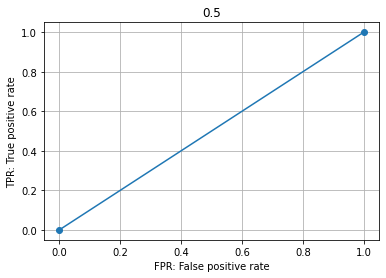

In [69]:
from sklearn.metrics import roc_auc_score, roc_curve
x = submission["extravasation_injury"]
y = df_valid["extravasation_injury"]
fpr, tpr, thresholds = roc_curve(y, x)
auc = roc_auc_score(y, x)
plt.plot(fpr, tpr, marker='o')
plt.title(auc)
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

mean: 0.707
99%tile: 0.72
95%tile:0.69
90%tile: 0.68
get_numerical_prediction: 0.718

In [70]:
# add weight
solution_train = create_training_solution(df_valid)

no_scale_score = score(solution_train.copy(),submission.copy(),'patient_id')
print(f'Training score without scaling: {no_scale_score:.4f}')

bowel: 0.1654
extravasation: 0.8514
kidney: 0.7129
liver: 0.8789
spleen: 0.9942
any_injury: 1.1569
mean: 0.7933
Training score without scaling: 0.7933


In [71]:
# Group by different sample weights
scale_by_2 = ['bowel_injury', 'kidney_low','liver_low','spleen_low']
scale_by_4 = ['kidney_high','liver_high','spleen_high']
scale_by_6 = ['extravasation_injury']

# Scale factors based on described metric 
sf_2 = 2
sf_4 = 4
sf_6 = 2

# Reset the prediction
y_pred = submission.copy()

# Scale each target 
y_pred[scale_by_2] *=sf_2
y_pred[scale_by_4] *=sf_4
y_pred[scale_by_6] *=sf_6

weight_scale_score = score(solution_train.copy(),y_pred.copy(),'patient_id')
print(f'Training score with weight scaling: {weight_scale_score:.4f}')

bowel: 0.1596
extravasation: 0.7108
kidney: 0.7576
liver: 0.8500
spleen: 1.0300
any_injury: 0.8747
mean: 0.7304
Training score with weight scaling: 0.7304


In [83]:
bowel: 0.1596
extravasation: 0.5070
kidney: 0.3229
liver: 0.5524
spleen: 0.5481
any_injury: 0.6071
mean: 0.4495
Training score with weight scaling: 0.4495

SyntaxError: invalid syntax (1466604250.py, line 8)

In [ ]:
bowel: 0.1596
extravasation: 0.5237
kidney: 0.3229
liver: 0.5524
spleen: 0.5928
any_injury: 0.6061
mean: 0.4596
Training score with weight scaling: 0.4596

bowel: 0.1508
extravasation: 0.5704
kidney: 0.3229
liver: 0.5524
spleen: 0.5928
any_injury: 0.6130
mean: 0.4671
Training score with weight scaling: 0.4671

mean, sf30
bowel: 0.1508
extravasation: 0.5519
kidney: 0.3229
liver: 0.5524
spleen: 0.5928
any_injury: 0.6203
mean: 0.4652
Training score with weight scaling: 0.4652